<i>Copyright (c) Microsoft Corporation. All rights reserved.</i>

<i>Licensed under the MIT License.</i>

# Train and deploy a custom image similarity web application

This notebook guides through the process of deploying a custom image similarity web application - from finetuning a RESNET50 model using a sample dataset in ImageNet directory structure format to updating required files for the web application and deploying them along with the model.

We will first finetune a pretrained ResNet18 model on a dataset in ImageNet directory structure using [fast.ai](https://www.fast.ai/). We will then use AzureML to deploy the model via Azure Apps Service and set CORS policies as also shown in [/scenarios/classification/25_deployment_on_azure_apps_service_and_setting_CORS_policies](../../../scenarios/classification/25_deployment_on_azure_apps_service_and_setting_CORS_policies.ipynb).

Finally, we will calculate features from the reference images and upload them with html and javascript files to deploy a web application that retrieves images with similar textile patterns.

## Initialization

In [1]:
# Regular python libraries
import os
import sys
import numpy as np
from pathlib import Path
import random

import scrapbook as sb

# fast.ai
import fastai
from fastai.vision import (
    accuracy,
    cnn_learner,
    DatasetType,
    ImageList,
    imagenet_stats,
    models,
    partial,
    PIL
)

# Computer Vision repository
sys.path.extend([".", "../../.."])  # to access the utils_cv library
from utils_cv.classification.data import Urls
from utils_cv.classification.model import TrainMetricsRecorder
from utils_cv.common.data import unzip_url
from utils_cv.common.gpu import which_processor, db_num_workers
from utils_cv.similarity.data import comparative_set_builder
from utils_cv.similarity.metrics import (
    positive_image_ranks,
    recall_at_k,
)
from utils_cv.similarity.model import compute_features, compute_features_learner
from utils_cv.similarity.widget import RetrievalWidget

print(f"Fast.ai version = {fastai.__version__}")
which_processor()

Fast.ai version = 1.0.57
Cuda is not available. Torch is using CPU


## Download the dataset and unzip it to a known location

Download and unzip the dataset into a known location and use the path for the `DATA_PATH` variable below.

Make sure your dataset is in ImageNet directory structure format.

NOTE: The sample dataset used here has a total of 1716 images divided into 11 classes: argyle, checkered, dotted, floral, herringbone, houndstooth, leopard, paisley, striped, tartan and zebra. 

In [2]:
# To use your own custom dataset in ImageNet directory structure, uncomment the line below
# and have DATA_PATH point to your the location of the unzipped dataset
# DATA_PATH = "YOUR-UNZIPPED-DATASET-LOCATION"
DATA_PATH = unzip_url(Urls.fridge_objects_path, exist_ok=True)

# DNN configuration and learning parameters
EPOCHS_HEAD = 7
EPOCHS_BODY = 10
LEARNING_RATE = 10* 1e-4
BATCH_SIZE = 16
ARCHITECTURE = models.resnet18
IM_SIZE = 300

Training set: 1373 images
Validation set: 343 images


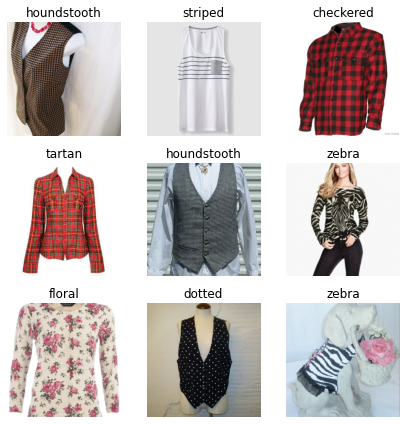

In [3]:
# Load images into fast.ai's ImageDataBunch object and split them into training and validation sets
random.seed(511)
data = (
    ImageList.from_folder(DATA_PATH)
    .split_by_rand_pct(valid_pct=0.2, seed=20)
    .label_from_folder()
    .transform(size=IM_SIZE)
    .databunch(bs=BATCH_SIZE, num_workers = db_num_workers())
    .normalize(imagenet_stats)
)

print(f"""\
Training set: {len(data.train_ds.x)} images
Validation set: {len(data.valid_ds.x)} images\
"""
)

# Display example images
data.show_batch(rows=3, figsize=(6, 6))

## ResNet18 CNN fine-tune & model export

Using the methods described in notebook [/scenarios/similarity/01_training_and_evaluation_introduction](../../../scenarios/similarity/01_training_and_evaluation_introduction.ipynb), we will retrieve a [ResNet18](https://arxiv.org/pdf/1512.03385.pdf) CNN using fast.ai and fine-tune the model using our fashion textile dataset. We will first train the last layer only, and then the full DNN.

In [4]:
learn = cnn_learner(
    data,
    ARCHITECTURE,
    metrics=[accuracy],
    callback_fns=[partial(TrainMetricsRecorder, show_graph=True)],
    ps=0 # Leave dropout at zero. Higher values tend to perform significantly worse
)

### First, only train the last layer

epoch,train_loss,valid_loss,train_accuracy,valid_accuracy,time
0,1.519488,1.206551,0.541193,0.740113,03:12
1,1.290838,2.322802,0.741477,0.598870,03:16
2,1.290515,1.387470,0.704545,0.666667,03:17
3,1.014254,0.737577,0.762784,0.824859,03:18
4,0.631062,0.580859,0.875000,0.853107,03:14
5,0.355842,0.600763,0.936080,0.824859,03:19
6,0.207222,0.628444,0.975852,0.819209,03:19


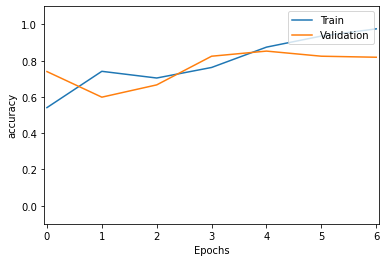

In [5]:
# Train the last layer using a larger rate since most of the DNN is fixed.
learn.fit_one_cycle(EPOCHS_HEAD, 10 * LEARNING_RATE)

### Now, let's fine-tune the full DNN

epoch,train_loss,valid_loss,train_accuracy,valid_accuracy,time
0,0.255167,1.317408,0.924716,0.700565,04:32
1,0.992316,3.660327,0.714489,0.485876,04:17
2,1.186169,2.939251,0.646307,0.440678,04:15
3,1.103605,2.075863,0.686080,0.564972,04:23
4,0.862986,1.817852,0.771307,0.548023,04:18
5,0.641886,1.009787,0.838068,0.745763,04:14
6,0.427670,0.672126,0.911932,0.790960,04:22
7,0.260598,0.793366,0.950284,0.796610,04:14
8,0.152652,0.606555,0.980114,0.830508,04:12
9,0.104243,0.610537,0.984375,0.830508,04:14


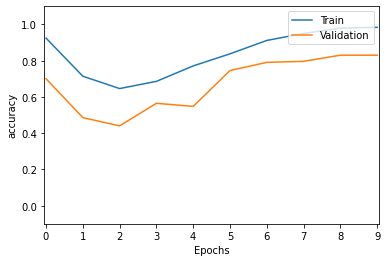

In [6]:
# Unfreeze all the layers and fine-tune the full DNN
learn.unfreeze()
learn.fit_one_cycle(EPOCHS_BODY, LEARNING_RATE)

### Export the fine-tuned model

In [7]:
# export the fine-tuned model into the current working directory
MODEL_NAME = "textile_pattern_model"
MODEL_PATH = os.path.join(os.getcwd(), MODEL_NAME)

learn.export(MODEL_PATH)

## Retrieve AzureML workspace and register the fine-tuned model for deployment

### Let's first import required modules for model deployment and retrieve your AzureML workspace

In [8]:
# Let's first import required modules for model deployment
import json
import requests
import sys
# This "sys.path.extend()" statement allows us to move up the directory hierarchy 
# and access the Computer Vision Repository utils_cv package
sys.path.extend([".", "../../.."])

# Import AzureML modules that are required for this notebook
from azureml.core import Workspace, Environment
from azureml.core.model import Model, InferenceConfig

# Import custom vision utilities for retrieving workspaces and for testing
from utils_cv.common.azureml import get_or_create_workspace
from utils_cv.common.data import data_path
from utils_cv.common.image import ims2strlist

In [9]:
subscription_id = "YOUR_SUBSCRIPTION_ID"
resource_group = "YOUR_RESOURCE_GROUP_NAME"  
workspace_name = "YOUR_WORKSPACE_NAME"  
workspace_region = "YOUR_WORKSPACE_REGION" #Possible values eastus, eastus2 and so on.

In [10]:
ws = get_or_create_workspace(
                subscription_id,
                resource_group,
                workspace_name,
                workspace_region)

# Let's print the workspace details
print("Workspace name: " + ws.name,
      "Workspace region: " + ws.location,
      "Subscription ID: " + ws.subscription_id,
      "Resource Group: " + ws.resource_group, sep = "\n")

### Register the exported model to your AzureML workspace for deployment

In [11]:
textile_pattern_model = Model.register(
    model_path = MODEL_PATH,
    model_name = MODEL_NAME,
    tags = {"Model": "Fine-tuned ResNet18 CNN model on fashion textile pattern dataset"},
    description = "Image similarity",
    workspace = ws
)

Registering model textile_pattern_model


## Scoring script

We will use a custom scoring script that saves the features in the intermediate layers and returns them in a JSON format so that they can be used to calculate the euclidean distances for retrieving similar images.

In [12]:
scoring_script = "score_similarity.py"

In [13]:
%%writefile $scoring_script
# Copyright (c) Microsoft. All rights reserved.
# Licensed under the MIT license.

import os
import json

from base64 import b64decode
from io import BytesIO

from azureml.core.model import Model
from fastai.vision import load_learner, open_image

# Required for image similarity to save the features in the intermediate layers
from torch.nn import Module
from torch import Tensor
import numpy as np

class SaveFeatures:
    """Hook to save the features in the intermediate layers
    Source: https://forums.fast.ai/t/how-to-find-similar-images-based-on-final-embedding-layer/16903/13
    Args:
        model_layer (nn.Module): Model layer
    """

    features = None

    def __init__(self, model_layer: Module):
        self.hook = model_layer.register_forward_hook(self.hook_fn)
        self.features = None

    def hook_fn(self, module: Module, input: Tensor, output: Tensor):
        out = output.detach().cpu().numpy()
        if isinstance(self.features, type(None)):
            self.features = out
        else:
            self.features = np.row_stack((self.features, out))

    def remove(self):
        self.hook.remove()

def init():
    global learner
    model_path = Model.get_model_path(model_name="textile_pattern_model")
    # ! We cannot use the *model_name* variable here otherwise the execution on Azure will fail !

    model_dir_path, model_filename = os.path.split(model_path)
    learner = load_learner(model_dir_path, model_filename)


def run(raw_data):

    # Expects raw_data to be a list within a json file
    result = []    
    
    for im_string in json.loads(raw_data)["data"]:
        im_bytes = b64decode(im_string)
        try:
            im = open_image(BytesIO(im_bytes))
            
            # feature extraction
            # use penultimate layer as image representation
            embedding_layer = learner.model[1][-2]
            
            featurizer = SaveFeatures(embedding_layer)
            featurizer.features = None
            
            pred_class, pred_idx, outputs = learner.predict(im)
            
            features = featurizer.features[0][:]
            featurizer.features = None

            result.append({"label": str(pred_class), 
                           "features": "[" + ','.join(map(lambda feature: str(feature), features)) + "]"})
        except Exception as e:
            result.append({"label": str(e)})
    return result

Writing score_similarity.py


## Retrieving your AzureML environment for the deployment

If you have not yet created your AzureML environment, please follow the steps in **section 3.D. Using AzureML Environments for Environment setup** in notebook: [/scenarios/classification/21_deployment_on_azure_container_instances](../../../scenarios/classification/21_deployment_on_azure_container_instances.ipynb#env)

Since the model used in the classification deployment notebook listed above is also using a fast.ai based ResNet18 model, the required dependencies for our deployment are the same, allowing us to reuse the same AzureML environment.

This notebook will assume that you already have an AzureML environment named `im_classif_resnet18` that is registered to your workspace.

In [14]:
resnet_tuned_env = Environment.get(workspace=ws, name="im_classif_resnet18")

## Build the image that will be used for the deployment

In [15]:
inference_config = InferenceConfig(entry_script="score_similarity.py", environment=resnet_tuned_env)

inference_image = Model.package(ws, [textile_pattern_model], inference_config)
# Setting show_output to True to stream the logs from the Docker image build process
inference_image.wait_for_creation(show_output=True)

## Deploy image as a web application

Follow the steps listed in sections **6. Model deployment as a web application** and **9. CORS** in [/scenarios/classification/25_deployment_on_azure_apps_service_and_setting_CORS_policies](../../../scenarios/classification/25_deployment_on_azure_apps_service_and_setting_CORS_policies.ipynb#deploy) to deploy the inference image that we built in the cell above and to set the correct CORS policies.

NOTE: The steps listed below assume that you have successfully deployed your model as a web application using Azure Apps Service and that the correct CORS setting has been set to allow REST API calls from our static website to the deployed model.

## Feature extraction and upload calculated features

We will use the penultimate layer as the image representation and calculate the features for the validation images which are used to retreive similar images as shown in [1_image_similarity_export](1_image_similarity_export.ipynb).

Follow the steps listed in sections **Feature extraction** and **Export for HTML Interface**, which will guide you through the processes of feature extraction and uploading of calculated features to Azure Blob Storage.

**NOTE: Remember that you already have your learner `learn` in-memory which should be used to calculate the features**

ex: `embedding_layer = learn.model[1][-2]`

## Upload files required for deploying the static HTML web application

Follow the steps in notebook: [2_upload_ui](2_upload_ui.ipynb)

The notebook linked above will guide you through deploying the static web page application, which in our case is as simple as uploading the required files (HTML, javascript, css files) to Azure blob storage.

**NOTE: Update hard-coded paths pointing to CVBP's blob in `/UICode/index.html`, `/UICode/script.js` and replace them with the corresponding directories in your blob storage. A quick search for `https://cvbp.blob.core.windows.net/` will help you find the paths you will need to modify.**